# Introduction

https://github.com/beha9089/DTSA5511_Final

## Abstract
In this report, we perform NLP on patient drug reviews to classify overall patient satisfaction (favorable/unfavorable rating) using review text alone. We build several Recurrent Neural Network models for this classification task and contrast their results. Allowing variable training times via early stopping, our RNNs achieved F1 Scores of 81-83% (negative class) and 92-93% (positive class) in binary classification.

## Data
We are utilizing the Drug Review Dataset (Drugs.com) created by Surya Kallumadi and Felix Grer, as made available by the UCI Machine Learning Repository at https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com.

The dataset consists of 215K patient drug reviews paired with a rating indicative of overall satisfaction. The reviews range in length from single word responses to small essays; ratings are whole numbers from 1.0 to 10.0. The data are split 70/30 between train and test sets.
## Resources
https://www.tensorflow.org/text/tutorials/text_classification_rnn

## Preliminaries

We begin with package imports and loading the data. We'll use TensorFlow and Keras for the RNN models, so we'll import layers, and we'll specifically bring in the TextVectorization layer; and we'll also be using the TfidfVecotorizer from scikit-learn, as well as their splitting function and their metrics library. The HTML package will be used to decode HTML entities in the text.

The data were previously downloaded from the UCI ML Repo and uploaded to Drive.

In [ ]:
import html
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# Mount to my Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/DTSA5511_Final/Data/'

train_df = pd.read_csv(base_path + 'drugsComTrain_raw.tsv', sep = '\t')
test_df = pd.read_csv(base_path + 'drugsComTest_raw.tsv', sep = '\t')

# Drop the index column
train_df.drop(columns = 'Unnamed: 0', inplace = True)
test_df.drop(columns = 'Unnamed: 0', inplace = True)

print(f'train_df has shape {train_df.shape}')
print(f'test_df has shape {test_df.shape}')

train_df has shape (161297, 6)
test_df has shape (53766, 6)


In [ ]:
train_df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


# Clean Up and EDA

## Clean Up

As these are data scraped from the web, there are some data quality issues that we will address before moving into our EDA. Here we will:

  1) Clean up the condition column by filling NAs/blanks and removing bad values, which are identified with a special character sequence;

  2) Remove duplicate records, where records with identifcal review, date, and rating are considered to be duplicated;

  3) Process the review text by decoding HTML entities, converting to lowercase, and then removing any non alphabetic characters, storing the resulting text in a new 'review_clean' column.

We build functions for each of these three steps to simplify the clean up of both train and test sets. However, these functions are not used anywhere else in the code.

### Clean Up Condition

Below we define a function to preprocess 'condition' and call it on both the test and train data. This step necessarily comes first as the next preprocess step removes duplicates in part based on the value of condition. Here we simply overwrite both NA and bad values to an empty string so that these are not differentiated in the duplicate check. The bad values were found during initial EDA and appear to be a parsing error and we do not consider these valid.

In [ ]:
# Define a function to replace bad values in the condition column. Reports on results
# Bad values are defined as blanks and parsing errors, identified as those containing '</'
def clean_condition(df):
  # Fill NA values
  is_na = df['condition'].isna()
  print(f'There are {np.sum(is_na)} NA values in condition ({round(np.sum(is_na)/len(is_na), 3)*100}%)')
  df.loc[is_na, 'condition'] = ''

  # Find bad values using the search string '</'
  bad_condition_val = df['condition'].str.contains('</', na = False)
  print(f'There are {np.sum(bad_condition_val)} records with a bad value in condition ({round(np.sum(bad_condition_val)/len(bad_condition_val), 3)*100}%)')
  df.loc[bad_condition_val, 'condition'] = ''

# Clean train and test
print('Clean condition in train_df')
clean_condition(train_df)
print('Clean condition in test_df')
clean_condition(test_df)

Clean condition in train_df
There are 899 NA values in condition (0.6%)
There are 900 records with a bad value in condition (0.6%)
Clean condition in test_df
There are 295 NA values in condition (0.5%)
There are 271 records with a bad value in condition (0.5%)


### Remove Duplicates

During initial EDA we found replication of some records, such as the example printed below, where it appears that a particular review for the drug Zovia was captured under both the brandname and the generic. We remove such duplicate records by considering the review text, the rating, and the date: If two or more records are identical in these three features, then we retain only one, without consideration for which record is kept. This avoids removing trivial reviews (e.g., "didn't work", "works great!") and avoids the case of a drug recorded under various names or conditions.

Unfortunately a significant portion (approx. 1/3) of the training records are duplicates, and are thus removed. This means that instead of training our model with 161K records, we train with 112K.

In [ ]:
# Drug is listed under generic and brandname
train_df.loc[[22486, 61531]]

,drugName,condition,review,rating,date,usefulCount
22486,Zovia,Birth Control,"""Zovia cleared my acne and helped regulate my ...",2.0,"August 21, 2013",11
61531,Ethinyl estradiol / ethynodiol,Birth Control,"""Zovia cleared my acne and helped regulate my ...",2.0,"August 21, 2013",11


In [ ]:
# Remove the records which duplicate review, rating, and date
def remove_duplicates(df, data_set):
  review_is_duped = df.review.duplicated()
  print(f'There are {np.sum(review_is_duped)} duplicate reviews in the {data_set} data')

  records_before = df.shape[0]
  # Duplicates have the same review, rating, and data
  df.drop_duplicates(['review', 'rating', 'date'], inplace = True)
  records_after = df.shape[0]
  removed = records_before - records_after
  print(f'{removed} duplicates were removed ({round(removed/records_before*100, 3)}% of the {data_set} data)')

# Process train and test
remove_duplicates(train_df, 'train')
print('')
remove_duplicates(test_df, 'test')

There are 48968 duplicate reviews in the train data
48731 duplicates were removed (30.212% of the train data)

There are 5486 duplicate reviews in the test data
5427 duplicates were removed (10.094% of the test data)


### Process Review

Finally, before our EDA we process the review text, producing a 'review_clean' column, which will be used as the basis for the EDA and our models. We first use the unescape method from the HTML library to decode HTML entities, such as quotation symbols and special characters which are present in the text as their HTML code representation. We then lowercase and strip the text of special characters.

In [ ]:
def process_reviews(df, data_set):
  print(f'Processing the {data_set} data . . .')
  # Unescape HTML codes
  df['review'] = [html.unescape(review) for review in df.review]
  # Create a new field for the processed reviews
  df['review_clean'] = df['review']
  # Convert to lowercase
  df['review_clean'] = df['review_clean'].str.lower()
  # Strip special characters, numbers, and other such non-alphabetic elements
  df['review_clean'] = df['review_clean'].str.replace(r'[^a-zA-Z ]', ' ', regex = True)
  print('\tDone!')

process_reviews(train_df, 'train')
process_reviews(test_df, 'test')

Processing the train data . . .
	Done!
Processing the test data . . .
	Done!


## EDA

### Basic Feature Summaries and Statistics

The summaries below show the wide variety of drugName and condition values (3,096 differnt drugs and 809 conditions), with the largest number of records being birth control medications. Unfortunately experimentation with these two features -- adding to the review_clean feature for modeling -- showed no improvement to our RNN models. So we will not be using either of these features in our modeling.

In [ ]:
train_df['drugName'].value_counts()

Levonorgestrel                       2318
Etonogestrel                         2074
Ethinyl estradiol / norethindrone    1749
Phentermine                          1386
Ethinyl estradiol / norgestimate     1374
                                     ... 
Unisom SleepMelts                       1
Duet DHA                                1
Viramune                                1
Plegridy                                1
Aldomet                                 1
Name: drugName, Length: 3096, dtype: int64

In [ ]:
train_df['condition'].value_counts()

Birth Control       18134
Depression           6291
Pain                 4457
Anxiety              4341
Acne                 3955
                    ...  
Cholera                 1
AV Heart Block          1
Wilson's Disease        1
Sepsis                  1
Neutropenia             1
Name: condition, Length: 809, dtype: int64

Below we compute summary statistics of rating and plot a histogram. Additionally, we get statistics on usefulCount, but because we do not use this feature we do not spend time analyzing its characteristics.

Reasonably, rating values range from 1 to 10, with the distribution biasing heavily towards higher scores (the median value is 8.0) despite a large sample in the lowest possible score. This is suggestive of a commonly observed bias in user/consumer ratings (reporter bias) where those with strong opinions/experiences dominate the response pool while those with expected or acceptable results do not respond. This would explain the low sample in scores 2.0 through 6.0.



In [ ]:
train_df.describe()

,rating,usefulCount
count,112566.000000,112566.00000
mean,7.000098,27.42639
std,3.271169,35.66415
min,1.000000,0.00000
25%,5.000000,6.00000
50%,8.000000,16.00000
75%,10.000000,36.00000
max,10.000000,1291.00000


<Axes: xlabel='rating'>

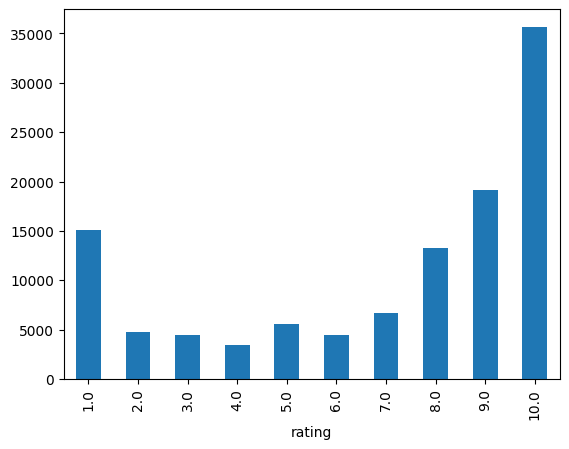

In [ ]:
train_df.groupby(['rating'])['rating'].count().plot.bar()

### Summaries and Statistics of Engineered Features

Below we define three new features based on review_clean

1. review_words: Tokenized text split on white space (as special characters have been removed, a contraction such as "I'm" will be tokenized as "I, m", for example);

2. review_len: The total length of the review_clean text; and

3. review_num_words: The number of "words" (tokens) in review_words.

We then compute overall summary statistics, as well as min, max, and average values by rating on the second two. Notably, the min and max in both features are abnormal, indicating the presence of both reviews with no valid words and reviews the length of a small essay. But these are the realities faced by real-world models considering free-form user input. Interestingly, we see the greatest outlier in terms of length and word count rated the drug at a 2.0. Beyond this oddity, we see the ratings with the highest sample exhibiting the greatest variance in review length and words.

Most reviews are around 450 characters long and most consist of around 84 words. We see signifcant outliers in length and word count in each rating.

In [ ]:
train_df['review_words'] = train_df['review_clean'].str.split()
train_df['review_len'] = train_df['review_clean'].str.strip().str.len()
train_df['review_num_words'] = train_df['review_words'].str.len()

print(train_df[['review_len', 'review_num_words']].describe())
print('\nReview length and word/token count by rating (mean, min, max):')
train_df[['rating', 'review_len', 'review_num_words']].groupby(['rating']).agg(['mean', 'median', 'min', 'max'])

          review_len  review_num_words
count  112566.000000     112566.000000
mean      445.298181         84.310085
std       237.029467         45.132089
min         0.000000          0.000000
25%       253.000000         48.000000
50%       441.000000         84.000000
75%       673.000000        126.000000
max     10428.000000       1917.000000

Review length and word/token count by rating (mean, min, max):


review_len                   review_num_words                 
              mean median min    max             mean median min   max
rating                                                                
1.0     414.577425  390.0   3   3659        78.205098   73.0   1   710
2.0     439.662713  432.0   7  10428        83.258843   82.0   2  1917
3.0     445.090767  438.0   6   4988        84.570696   84.0   1   888
4.0     448.638255  441.0   4   2952        85.331407   84.0   1   561
5.0     461.985328  463.0   4   1955        87.927894   89.0   1   385
6.0     452.140915  450.0   2   2122        85.860444   86.0   1   376
7.0     468.782150  479.0   4   2955        89.033771   91.0   1   585
8.0     468.868119  479.5   1   3984        88.762931   91.0   1   758
9.0     464.311328  471.0   1   6069        87.818101   89.0   1  1106
10.0    431.967777  423.0   0   6080        81.728869   80.0   0  1169

<Axes: title={'center': 'review_len'}, xlabel='[rating]'>

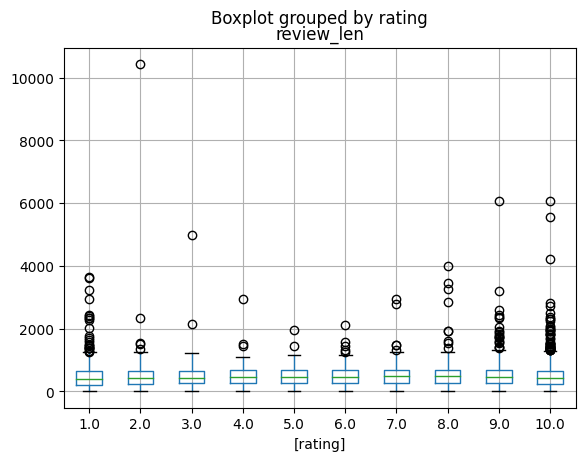

In [ ]:
train_df.boxplot(column = ['review_len'], by = ['rating'])

<Axes: title={'center': 'review_num_words'}, xlabel='[rating]'>

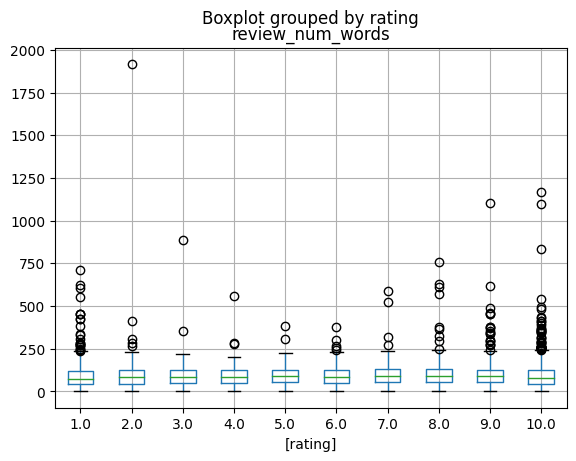

In [ ]:
train_df.boxplot(column = ['review_num_words'], by = ['rating'])

Before moving on from our EDA into preparing for modeling, we review the most common tokens in our corpus of reviews. Below we flatten all reviews into a single set and count the occurances of each token. This shows there are just shy of 46K tokens across all training reviews. As expected for such a collection, the top words are articles, basic prepositions, and simple words, which will be of little use in our models.

In [ ]:
# Flatted the tweets into a single list of words
train_words_flattened = [word for text in train_df['review_words'] for word in text]
train_words_series = pd.Series(train_words_flattened).value_counts(normalize = True)

print(f'There are {len(train_words_series)} distinct words/tokens in the training data')

# Get the relative frequency of the top words in the data
top_k_words = 15
print(f'The top {top_k_words} are: ')
train_words_series[0:top_k_words]


There are 45910 distinct words/tokens in the training data
The top 15 are: 


i       0.062597
and     0.031681
the     0.029820
to      0.023766
it      0.023151
my      0.021326
a       0.021310
for     0.014808
was     0.012896
of      0.012638
have    0.012548
this    0.010037
on      0.009976
in      0.009363
but     0.009027
dtype: float64

# Model Preliminaries

Before moving onto creating our models, we take care of a few necessary preliminaries. First, we define our target feature (favorable_rating), a binary indicator for ratings of 6.0 and higher (accounting for 70% of training records). We then define our vocabulary, based on the training data alone, which we will pass into our text vectorizer, the first layer of our models. Finally, we define two helper functions which will be used to display model results.

In [ ]:
train_df['favorable_rating'] = (train_df['rating'] > 5.0).astype('int')
test_df['favorable_rating'] = (test_df['rating'] > 5.0).astype('int')

In [ ]:
print(f'{round(sum(train_df.favorable_rating)/len(train_df.favorable_rating)*100, 2)}% of train records have a favorable rating')
train_df['favorable_rating'].value_counts()

70.29% of train records have a favorable rating


1    79121
0    33445
Name: favorable_rating, dtype: int64

Here we define a TfidfVectorizer, fitted to the train data, to build our vocabulary, which we will feed intor our textvectorizer. We set the optional parameters for min and max document frequencies, to place limits on words based on their occurances in the corpus, as well as a short list of words to explicitly exclude from the vocabulary.

In [ ]:
stop_words = ['aboard','about','above','across','after','against','along','amid','among','anti','around','as','at','before','behind',
              'below','beneath','beside','besides','between','beyond','but','by','concerning','considering','despite','down','during',
              'except','excepting','excluding','following','for','from','in','inside','into','like','minus','near','of','off','on',
              'onto','opposite','outside','over','past','per','plus','regarding','round','save','since','than','through','to','toward',
              'towards','under','underneath','unlike','until','up','upon','versus','via','with','within','without'
              ]

vectorizer = TfidfVectorizer(strip_accents = 'ascii', min_df = 0.0005, max_df = .6, stop_words = stop_words)

vectorizer.fit(train_df['review_clean'])

print(f'There are {len(vectorizer.vocabulary_.keys())} words in the vocabulary')
print(f'There are {len(list(vectorizer.stop_words_))} words in the stop words set\n')
print('Vocabulary sample:\n', vectorizer.get_feature_names_out()[0:20])
print('Stop word sample:\n', list(vectorizer.stop_words_)[0:20])

There are 4748 words in the vocabulary
There are 41067 words in the stop words set

Vocabulary sample:
 ['aa' 'abdomen' 'abdominal' 'abilify' 'ability' 'ablation' 'able'
 'abnormal' 'abortion' 'abreva' 'abruptly' 'abscess' 'absolute'
 'absolutely' 'absorb' 'absorbed' 'abuse' 'abused' 'abusing' 'accept']
Stop word sample:
 ['countered', 'higschool', 'clinching', 'naseua', 'skinceuticals', 'vivell', 'oneness', 'carousel', 'valproic', 'irratibility', 'carboholic', 'whined', 'dousing', 'petbo', 'agitaged', 'pleanty', 'rogain', 'dulco', 'synvice', 'pharmac']


In [ ]:
# Graph the train and validation loss and accuracy across two paired plots
def plot_model_fit_history(training_hist, model_name):
    # Create two plots with a shared X-axis
    fig, axs = plt.subplots(2, 1, sharex = True)
    # Remove vertical space between axes
    fig.subplots_adjust(hspace = 0)
    # Plot losses
    axs[0].plot(training_hist.history['loss'])
    axs[0].plot(training_hist.history['val_loss'])
    axs[0].legend(['Train', 'Validation'], loc = 'upper left')
    axs[0].set_ylabel('Loss')
    # Plot accuracy
    axs[1].plot(training_hist.history['accuracy'])
    axs[1].plot(training_hist.history['val_accuracy'])
    axs[1].legend(['Train', 'Validation'], loc = 'upper left')
    axs[1].set_ylabel('Accuracy')

    fig.supxlabel('Epoch')
    fig.suptitle(f'Training Loss and Accuracy for {model_name}')
    # Display
    plt.show()

In [ ]:
# Display a scikit-learn classification report and confusion matrix for the model results
def print_model_results(y_true, y_pred, model_name):
  # Print the classification report
  print(metrics.classification_report(y_true, y_pred, digits = 3))
  # Define the confusion matrix
  cm = metrics.confusion_matrix(y_true, y_pred)
  # Display the confusion matrix
  dsp = metrics.ConfusionMatrixDisplay(cm)
  dsp.plot()
  plt.title(f'Confusion Matrix for {model_name}')
  plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Binary Models
Below we define our RNN models for the binary classification task. We first define our vectorization layer and prepare the train and test (validation data) by passing it through the layer and batch and prefetch it as a TF Dataset, which will help the models run efficiently.

The vectorize layer simply takes the previously defined vocabulary and uses this to vectorize text, by converting each sample into a vector of integer indices corresponding to words in the vocabulary.

In [ ]:
# Create an alternate vectorize_layer using the vocab from the TFIDF vectorizer
vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    vocabulary = list(vectorizer.vocabulary_.keys()),
                                    output_mode = 'int',
                                   )
# Vectorize the training data
train_ds = vectorize_layer(train_df['review_clean'])
test_ds = vectorize_layer(test_df['review_clean'])

batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_df['favorable_rating'])).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_df['favorable_rating'])).batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Model 0
A very simple RNN, this model consists of just an embedding, a bi-directional GRU, and a classifier. We specify a binary cross-entropy loss and a RMSprop optimizer. We then run the training sequence for 20 epochs with an early stopping condition to end training after three epochs without improvement in the validation loss. Note here that we are masking zeros in the embedding, which gives us a bit of a performance boost in ignoring the zero padding in our vectorized text.

In [ ]:
model0 = keras.Sequential([layers.Embedding(len(vectorizer.vocabulary_.keys()), 64, mask_zero = True),
                          layers.Bidirectional(layers.GRU(64)),
                          layers.Dense(1, activation = 'sigmoid')
                         ])
model0.summary()

model0.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-3), metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          303872    
                                                                 
 bidirectional (Bidirection  (None, 128)               49920     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 353921 (1.35 MB)
Trainable params: 353921 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
880/880 - 83s - loss: 0.4285 - accuracy: 0.8042 - val_loss: 0.3543 - val_accuracy: 0.8461 - 83s/epoch - 94ms/step
Epoch 2/20
880/880 - 34s - loss: 0.3609 - accuracy: 0.8440 - val_loss: 0.3420 - val_accuracy: 0.8525 - 34s/epoch - 39ms/step
Epoch 3/20
880/880 - 34s - loss: 0.3445 - accuracy: 0.8524 - val_loss: 0.3330 - val_accuracy: 0.8573 - 34s/epoch - 39ms/step
Epoch 4/20
880/880 - 34s - loss: 0.3324 - accuracy: 0.8579 - val_loss: 0.3250 - val_accuracy: 0.8611 - 34s/epoch - 38ms/step
Epoch 5/20
880/880 - 34s - loss: 0.3206 - accuracy: 0.8635 - val_loss: 0.3158 - val_accuracy: 0.8649 - 34s/epoch - 38ms/step
Epoch 6/20
880/880 - 34s - loss: 0.3081 - accuracy: 0.8698 - val_loss: 0.3071 - val_accuracy: 0.8698 - 34s/epoch - 39ms/step
Epoch 7/20
880/880 - 34s - loss: 0.2963 - accuracy: 0.8754 - val_loss: 0.2993 - val_accuracy: 0.8735 - 34s/epoch - 39ms/step
Epoch 8/20
880/880 - 34s - loss: 0.2849 - accuracy: 0.8812 - val_loss: 0.2916 - val_accuracy: 0.8783 - 34s/epoch - 38ms/step


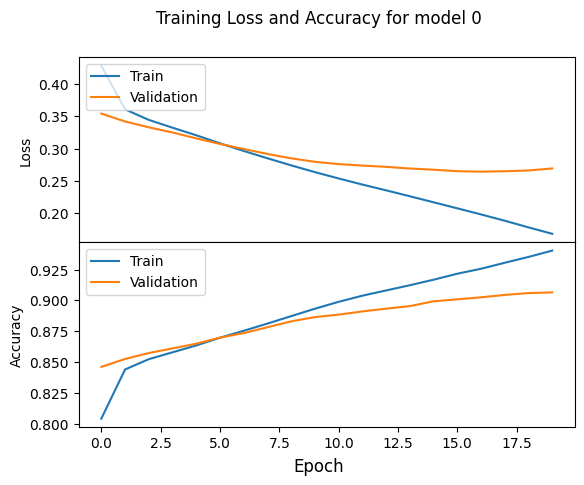

In [ ]:
earl_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min')
model_hist0 = model0.fit(x = train_ds, epochs = 20, validation_data = test_ds, callbacks = [earl_stop], verbose = 2)

plot_model_fit_history(model_hist0, 'model 0')

### Model 1

Here we somewhat expand on our first model by adding an additional bi-directional GRU and a dense layer prior to the activation. Our embedding is unchanged from model 0 but we cut the output of the GRU in half; the following GRU has output size reduced again by one-half.

In [ ]:
model1 = keras.Sequential([layers.Embedding(len(vectorizer.vocabulary_.keys()), 64, mask_zero = True),
                          layers.Bidirectional(layers.GRU(32, return_sequences = True)),
                          layers.Bidirectional(layers.GRU(16)),
                          layers.Dense(64, activation = 'relu'),
                          layers.Dense(1, activation = 'sigmoid')
                         ])
model1.summary()

model1.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-3), metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          303872    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          18816     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                7872      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 332737 (1.27 MB)
Trainable params: 33273

Epoch 1/20
880/880 - 110s - loss: 0.4272 - accuracy: 0.8048 - val_loss: 0.3532 - val_accuracy: 0.8466 - 110s/epoch - 125ms/step
Epoch 2/20
880/880 - 67s - loss: 0.3561 - accuracy: 0.8462 - val_loss: 0.3375 - val_accuracy: 0.8551 - 67s/epoch - 76ms/step
Epoch 3/20
880/880 - 68s - loss: 0.3384 - accuracy: 0.8554 - val_loss: 0.3283 - val_accuracy: 0.8598 - 68s/epoch - 77ms/step
Epoch 4/20
880/880 - 67s - loss: 0.3250 - accuracy: 0.8616 - val_loss: 0.3186 - val_accuracy: 0.8638 - 67s/epoch - 77ms/step
Epoch 5/20
880/880 - 67s - loss: 0.3115 - accuracy: 0.8682 - val_loss: 0.3076 - val_accuracy: 0.8698 - 67s/epoch - 76ms/step
Epoch 6/20
880/880 - 67s - loss: 0.2973 - accuracy: 0.8749 - val_loss: 0.2980 - val_accuracy: 0.8745 - 67s/epoch - 76ms/step
Epoch 7/20
880/880 - 67s - loss: 0.2842 - accuracy: 0.8818 - val_loss: 0.2906 - val_accuracy: 0.8783 - 67s/epoch - 77ms/step
Epoch 8/20
880/880 - 68s - loss: 0.2722 - accuracy: 0.8885 - val_loss: 0.2849 - val_accuracy: 0.8822 - 68s/epoch - 77ms/st

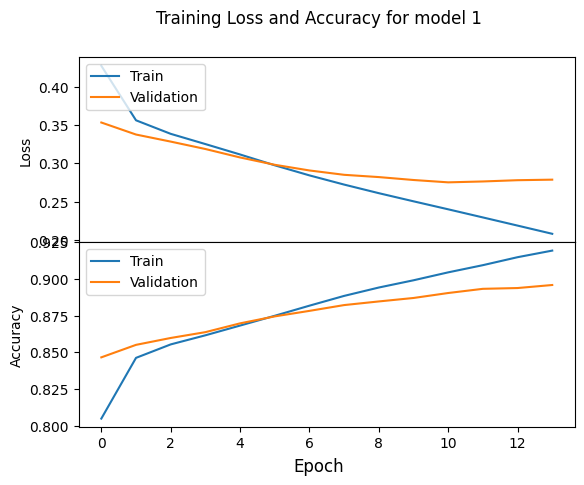

In [ ]:
earl_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min')
model_hist1 = model1.fit(x = train_ds, epochs = 20, validation_data = test_ds, callbacks = [earl_stop], verbose = 2)

plot_model_fit_history(model_hist1, 'model 1')

### Model 2
Our next model has the same initial structure as the prior two -- the vectorized text is fed into an embedding layer which masks zeros -- but expands with additional layers. Here we have kept the bi-directional GRU from the first model and added two more standard GRUs; these GRUs are followed by two dense layers with ReLU activation.

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 2000, decay_rate = 0.96, staircase = True)
model2 = keras.Sequential([layers.Embedding(len(vectorizer.vocabulary_.keys()), 64, mask_zero = True),
                          layers.Bidirectional(layers.GRU(64, return_sequences = True)),
                          layers.GRU(64, return_sequences = True),
                          layers.GRU(64),
                          layers.Dense(64, activation = 'relu'),
                          layers.Dense(32, activation = 'relu'),
                          layers.Dense(1, activation = 'sigmoid')
                         ])
model2.summary()

model2.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-3), metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          303872    
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 128)         49920     
 onal)                                                           
                                                                 
 gru_4 (GRU)                 (None, None, 64)          37248     
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

Epoch 1/20
880/880 - 118s - loss: 0.4479 - accuracy: 0.7958 - val_loss: 0.3767 - val_accuracy: 0.8397 - 118s/epoch - 134ms/step
Epoch 2/20
880/880 - 71s - loss: 0.3801 - accuracy: 0.8365 - val_loss: 0.3626 - val_accuracy: 0.8463 - 71s/epoch - 80ms/step
Epoch 3/20
880/880 - 70s - loss: 0.3647 - accuracy: 0.8449 - val_loss: 0.3536 - val_accuracy: 0.8500 - 70s/epoch - 80ms/step
Epoch 4/20
880/880 - 70s - loss: 0.3488 - accuracy: 0.8521 - val_loss: 0.3332 - val_accuracy: 0.8581 - 70s/epoch - 80ms/step
Epoch 5/20
880/880 - 71s - loss: 0.3301 - accuracy: 0.8603 - val_loss: 0.3196 - val_accuracy: 0.8638 - 71s/epoch - 81ms/step
Epoch 6/20
880/880 - 72s - loss: 0.3148 - accuracy: 0.8677 - val_loss: 0.3110 - val_accuracy: 0.8700 - 72s/epoch - 82ms/step
Epoch 7/20
880/880 - 71s - loss: 0.3018 - accuracy: 0.8743 - val_loss: 0.3047 - val_accuracy: 0.8740 - 71s/epoch - 81ms/step
Epoch 8/20
880/880 - 70s - loss: 0.2902 - accuracy: 0.8807 - val_loss: 0.3000 - val_accuracy: 0.8763 - 70s/epoch - 80ms/st

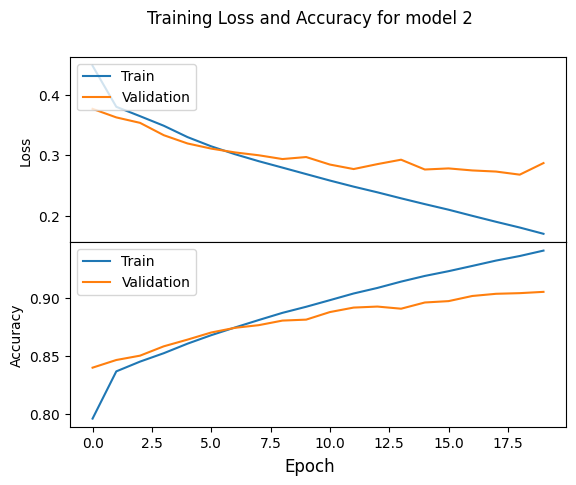

In [ ]:
earl_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min')
model_hist2 = model2.fit(x = train_ds, epochs = 20, validation_data = test_ds, callbacks = [earl_stop], verbose = 2)

plot_model_fit_history(model_hist2, 'model 2')

## Results

Despite the difference in architecture across our three models, we see quite similar performance in learning the binary classification task on the review text. However, our first model, an extremely simple RNN consisting of a vectorizer, an embedding, one bi-directional GRU, and a classifier, out-performed the subsequent two models, as judged by F1-score in the negative and positive classes:

* Model 0: 84.1%, 93.4%

* Model 1: 82.0%, 92.7%

* Model 2: 83.9%, 93.3%

              precision    recall  f1-score   support

           0      0.863     0.820     0.841     14545
           1      0.924     0.944     0.934     33794

    accuracy                          0.906     48339
   macro avg      0.893     0.882     0.887     48339
weighted avg      0.906     0.906     0.906     48339



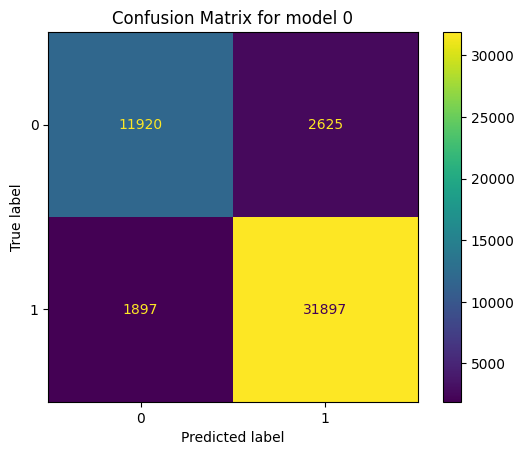

              precision    recall  f1-score   support

           0      0.855     0.787     0.820     14545
           1      0.912     0.943     0.927     33794

    accuracy                          0.896     48339
   macro avg      0.883     0.865     0.873     48339
weighted avg      0.895     0.896     0.895     48339



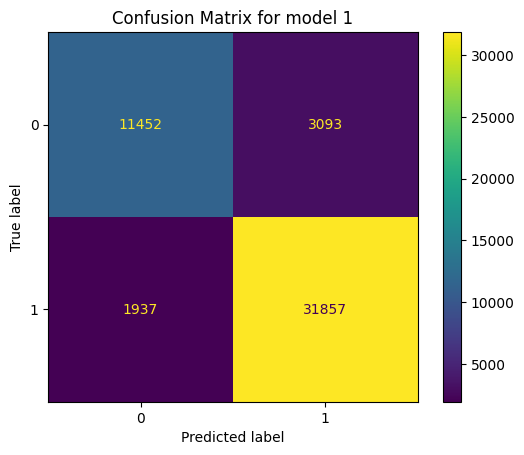

              precision    recall  f1-score   support

           0      0.854     0.825     0.839     14545
           1      0.926     0.940     0.933     33794

    accuracy                          0.905     48339
   macro avg      0.890     0.882     0.886     48339
weighted avg      0.904     0.905     0.905     48339



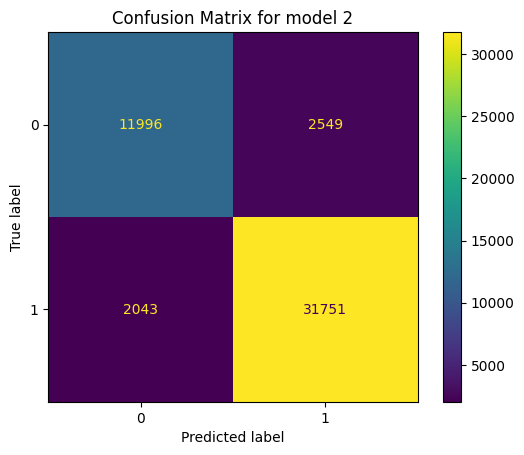

In [ ]:
val_X = vectorize_layer(test_df['review_clean'])

y_pred0 = model0.predict(val_X, verbose = 0)
y_pred0 = (y_pred0 > 0.5).astype('int')
print_model_results(test_df['favorable_rating'], y_pred0, 'model 0')

y_pred1 = model1.predict(val_X, verbose = 0)
y_pred1 = (y_pred1 > 0.5).astype('int')
print_model_results(test_df['favorable_rating'], y_pred1, 'model 1')

y_pred2 = model2.predict(val_X, verbose = 0)
y_pred2 = (y_pred2 > 0.5).astype('int')
print_model_results(test_df['favorable_rating'], y_pred2, 'model 2')

# Conclusion

In this report we performed an NLP analysis and modeled patient reviews of drugs to predict whether or not the patient had a favorable experience with the drug. After basic preprocessing, including text cleaning and removal of duplicates, we created a vocabulary on the training data, which we used to define a text vectorizer. The vectorized review texts were then fed into the models, of which we created three, for training. We began with an initial model to baseline (Model 0) and two alternate model complicated models. However, we found that Model 0 showed the highest classification performance on the test data, with F1-scores of 84.1% and 93.4% on the negative and positive classes.